# Mode Learning in 2D Navigation Tasks: A Tutorial

This tutorial explains the basic environmental setup of the 2D polygon domain and how to evaluate a model to do mode classification and mode-conditioned planning.

In [19]:
import os.path as osp
import torch
import sys
sys.path.insert(0, 'polygon_mode_learning')

## Data Visualization and Gym Environment Setup

Let's start from loading a pre-defined task. Please refer to the README file to create your own task.

Loaded task definition from data_gen/polygon_4/task.pkl
Number of modes: 5


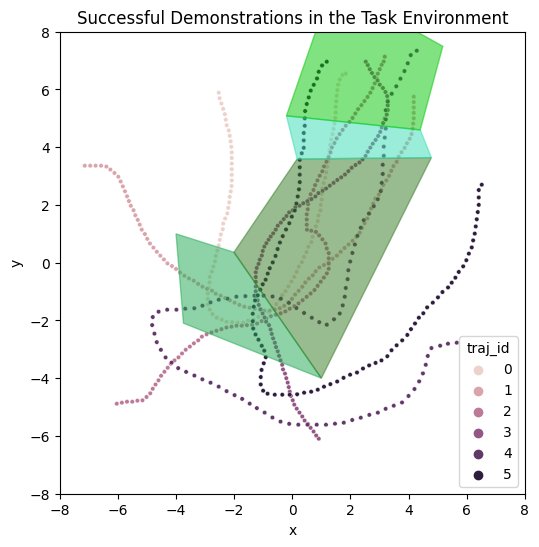

In [22]:
from augment_demo import *

task_dir = osp.join('data_gen', 'polygon_4') # you could load polygon_2, polygon_3 or polygon_4 to replicate results in the paper
task, df = load_drawn(task_dir)
print(f'Loaded task definition from {osp.join(task_dir, "task.pkl")}')
print(f'Number of modes: {len(task.modes)}') # number of polygon + initial background mode

# We can visualize the multimodal task environment and demonstrations.
visualize_drawn(task, df)


Let's visualize the perturbed trajectories.

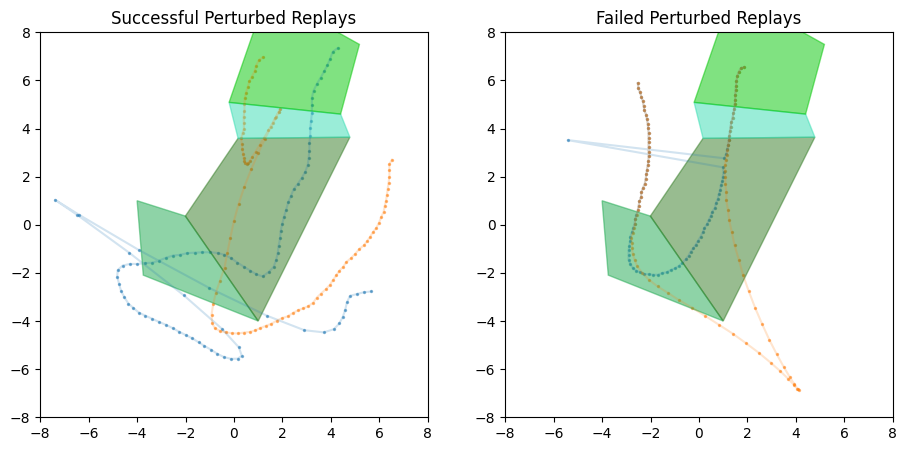

In [8]:
succ_data, fail_data = load_perturbed(task_dir, fail_file='fail_traj.npy', succ_file='succ_traj.npy')
start_idx = random.randint(0, len(succ_data) - 3)
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
plot_batch(task, succ_data[start_idx:start_idx+2], fig_ax=(fig, axes[0]), title='Successful Perturbed Replays')
plot_batch(task, fail_data[start_idx:start_idx+2], fig_ax=(fig, axes[1]), title='Failed Perturbed Replays')

We further construct an OpenAI Gym environment for the polygon domain, based on the task definition.

In [9]:
from polygon_mode_learning.gym_env import Polygon2DEnv

env = Polygon2DEnv(task, start_from_free=True)
state = env.reset()
print(f'Initial state: {state}')
for i in range(10):
    state, reward, done, info = env.step(env.action_space.sample())
    print(f'Step {i}: {state}, {reward}, {done}, {info}')

Initial state: (-0.7605347379739733, -5.631919796787537)
Step 0: (-0.6640913436623008, -5.605487398227375), 0, False, None
Step 1: (-0.5691055896057133, -5.636755697290507), 0, False, None
Step 2: (-0.5454309212262374, -5.539598556137004), 0, False, None
Step 3: (-0.608402695230103, -5.617280958769814), 0, False, None
Step 4: (-0.5312547282601605, -5.553655561384771), 0, False, None
Step 5: (-0.5102959946190501, -5.455876568323066), 0, False, None
Step 6: (-0.5965858176545292, -5.506414340736437), 0, False, None
Step 7: (-0.4980323854719459, -5.489466744888266), 0, False, None
Step 8: (-0.5265944557594431, -5.393632470534609), 0, False, None
Step 9: (-0.6116458872424348, -5.341037280614865), 0, False, None


## Utility of Learning a Mode Classifier

You can use these data to train a classifier to predict the mode for a given state (x, y). Here, due to the space limit, we will only focusing on evaluating a pre-trained model. For model training details, refer to the README file. 

In [34]:
from train_classifier import Net

num_modes = len(task.modes)
feasibility_matrix = np.array([
    [0.0,  0.0, -1.0, -2.0, -3.0],
    [0.0,  0.0,  0.0, -1.0, -2.0],
    [0.0,  0.0,  0.0,  0.0, -1.0],
    [0.0, -0.0,  0.0,  0.0, -0.0],
    [0.0, -0.0, -0.0,  0.0, -0.0]
])[:num_modes, :num_modes]

net = Net(num_layers=2, num_modes=num_modes, feas_mat=feasibility_matrix, num_guess=10)
net.load_state_dict(torch.load('weights/polygon_4/checkpoint_40000.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

### Interpretability: Visualization of the Learned Mode Grounding

One utility of recovering the multi-modal task structure is that it helps explain why some perturbed replays of demonstrations are failed task executions but not others. To visualize the learned mode classification, we first generate a grid of points in the state space, and then use the classifier to predict the mode for each point. The color of each point indicates the predicted mode.

Guess idx: 0 Overlap with Ground Truth Mode: 0.9646999835968018
Guess idx: 1 Overlap with Ground Truth Mode: 0.4927250146865845
Guess idx: 2 Overlap with Ground Truth Mode: 0.9539750218391418
Guess idx: 3 Overlap with Ground Truth Mode: 0.5890750288963318
Guess idx: 4 Overlap with Ground Truth Mode: 0.9748499989509583
Guess idx: 5 Overlap with Ground Truth Mode: 0.5393499732017517
Guess idx: 6 Overlap with Ground Truth Mode: 0.5246999859809875
Guess idx: 7 Overlap with Ground Truth Mode: 0.7613250017166138
Guess idx: 8 Overlap with Ground Truth Mode: 0.7410249710083008
Guess idx: 9 Overlap with Ground Truth Mode: 0.9659749865531921


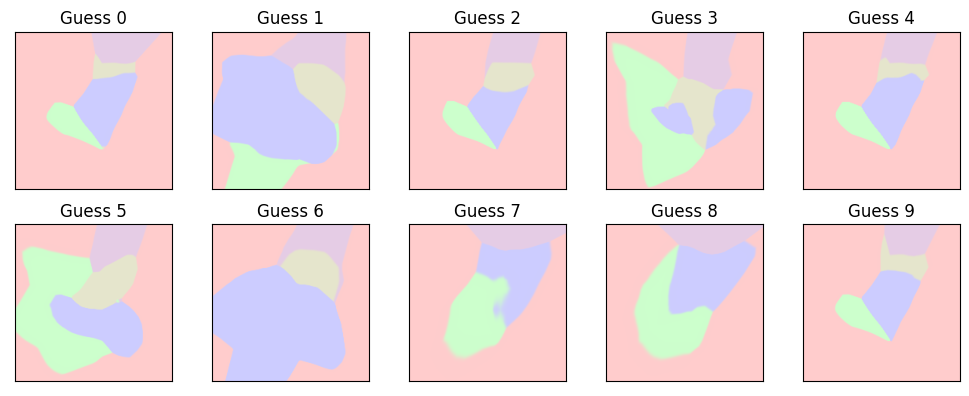

In [32]:
%matplotlib inline
from train_classifier import visualize_learned_modes

mode_all_guess, color_matrix = visualize_learned_modes(env, net)

The figure above shows that the classifer has 10 predictor heads, each learning a different grounding classifier in parallel. Empirically, we find optimizing over multiple grounding hypotheses concurently makes it easy for the network to find the groundtruth solution. We let readers to try themselves different checkpoints of the network weights to visualize the evolution of these mode bliefs throughout training. To select the best guess as our grounding model, we evaluate which candidate grounding can predict the execution outcomes of demonstration replays most accurately. Here, we will just use visual inspection to set `best_guess_idx=4` for this tutorial. 

In [12]:
net.best_guess_idx = 4
mode_belief = mode_all_guess.reshape(200, 200, net.num_guess, net.num_modes)[:, :, net.best_guess_idx, :]
mode_belief_argmax = mode_belief.argmax(-1).reshape(200, 200) # predicted modes over the state space
mode_color = torch.clamp(torch.matmul(mode_belief, color_matrix), min=0, max=1) # color visualization of predicted modes


### Robustness to Perturbations: Mode-Based Policy Visualization

Another utility of learning the grounding classifier is to faciliate replanning at the sub-task/mode level should external perturbations causes invalid mode trainsitions. The policy for each mode can either come from imitation learning over mode-based segmented demonstrations or motion planning if dynamics is known. For example, one can build a potential flow controller for each mode given recovered mode boundaries. This is done by first segmenting the successful demonstrations into mode-based trajecotries. Next, we compute the mean of the starting states of each set of segments, and use them as the attractors/waypoints to transition from one potential flow controller to the next. 

In [13]:
from polygon_mode_learning.motion_planning import compute_waypoints, compute_potential_flow

average_waypoints = compute_waypoints(succ_data, net)
grid_action, obstacles = compute_potential_flow(mode_belief_argmax, average_waypoints, net)

Potential field computation done (for visualization only)


We can further overlay the waypoints on the learned mode grounding. To visualize the policy given the learned mode classifier, we also plot the potential field induced by the classifier. The potential field is computed by choosing actions that point to the next waypoint while avoiding crossing invalid mode boundaries.

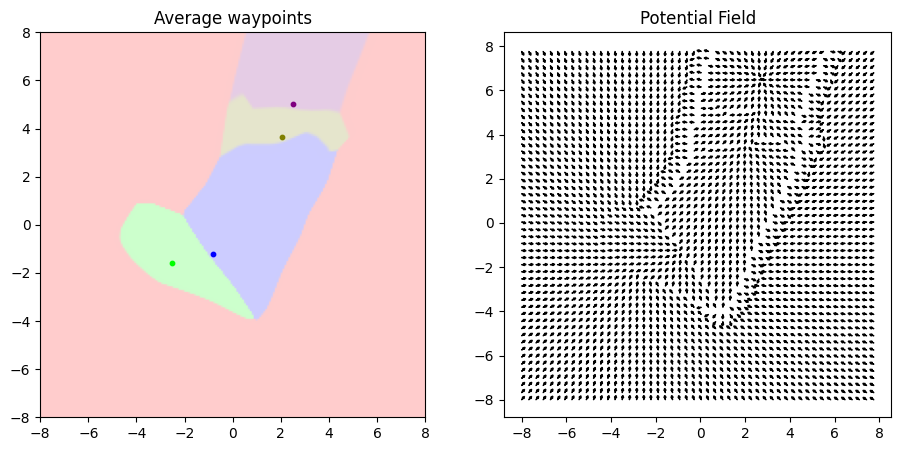

In [14]:
from polygon_mode_learning.motion_planning import visualize_waypoints, visualize_potential_flow

fig, axes = plt.subplots(1, 2, figsize=(11, 5))
visualize_waypoints(average_waypoints, net, mode_color, ax=axes[0])
visualize_potential_flow(mode_belief_argmax, grid_action, ax=axes[1])

### Replanning at the Task Level via Mode Grounding

While potential flow controller is sufficient for convex mode planning, it can lead to invalid mode transitions for our first non-convex mode (white region). Hence for the white region, we use RRT to plan motions to reach the first waypoint without crossing through later modes. The overall mode-conditioned policy is constructed in the following way:

- If we are currently in mode 0 (ouside any polygon), then we will move towards the first polygon by computing a collsion-free path using the RRT algorithm (we define a collision-free path as a path that does not cross any invalid transition boundaries).
- If we are currently in mode x (x > 0), then we directly move towards the next waypoint using potential flow controllers.

In [15]:
from polygon_mode_learning.motion_planning import run_episode

# Evaluate the success rate of the mode-conditioned planning given random perturbations
success_episodes = 0
episodes = 10
print('Running episodes...')
for i in range(episodes):
    rv, _ = run_episode(env, grid_action, mode_belief_argmax, average_waypoints, obstacles, save_video_dir=None)
    success_episodes += rv
    print(f'  Finished {i + 1}th episode')
print('Success rate: ', success_episodes / episodes)

Running episodes...
  Finished 1th episode
  Finished 2th episode
  Finished 3th episode
  Finished 4th episode
  Finished 5th episode
  Finished 6th episode
  Finished 7th episode
  Finished 8th episode
  Finished 9th episode
  Finished 10th episode
Success rate:  0.8


To visualize the behavior of the mode-conditioned policy under perturbations, save a video

In [18]:
from IPython.display import HTML
from base64 import b64encode

np.random.seed(42)
rv, video_saver = run_episode(env, grid_action, mode_belief_argmax, average_waypoints, obstacles, save_video_dir='figs')
video_filename = video_saver.finalize()

# Display the video.
mp4 = open(video_filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
        <source src="%s" type="video/mp4">
</video>
""" % data_url)